# Kickstarter Project
Tua Wongsangaroonsri, Elaine Ren, Kemjika Ananaba

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from datetime import timedelta

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline 

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Import Data

In [2]:
ks = pd.read_csv('ks-projects-201801.csv')

print(ks.shape)
print(ks.info())

(378661, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ 

## Data Cleaning

In [3]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ks['main_category'].value_counts())
    print(ks['category'].value_counts())

maincatcount = ks['main_category'].value_counts()
catcount = ks['category'].value_counts()

#maincatfilter = list(maincatcount.index[maincatcount<7000])
#catfilter = list(catcount.index[catcount<100])

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64
Product Design        22314
Documentary           16139
Music                 15727
Tabletop Games        14180
Shorts                12357
Video Games           11830
Food                  11493
Film & Video          10108
Fiction                9169
Fashion                8554
Nonfiction             8318
Art                    8253
Apparel                7166
Theater                7057
Technology             6930
Rock                   6758
Children's Books       6756
Apps                   6345
Publishing             6018
Webseries              5762
Photography            5752
Indie Rock             5657
Narrative Film      

In [4]:
print(ks.shape)
ks = ks[~ks['state'].isin(['undefined','live','suspended','canceled'])]
ks = ks[~ks['currency'].isin(['JPY'])]
print(ks.shape)

(378661, 15)
(331652, 15)


In [13]:
ks = ks.dropna()
ks['currency'] = ks.currency.astype('category')
ks['country'] = ks.country.astype('category')
ks['state'] = ks.state.astype('category')
ks['deadline'] = pd.to_datetime(ks['deadline'])
ks['launched'] = pd.to_datetime(ks['launched'])
ks['year'] = ks['launched'].dt.year
ks['year'] = ks.year.astype('category')
ks['daysavailable'] = ks['deadline'] - ks['launched'] 
ks['daysavailable'] = ks['daysavailable'].dt.days

ks_dropped = ks[ks['usd_goal_real']<ks['usd_goal_real'].quantile(0.99)]
ks_dropped.shape

(328083, 17)

Define new dataframe X that only include the relevant subset of columns

In [9]:
X = ks_dropped.drop(columns = ['ID','name','category','deadline','goal','launched','pledged','state','backers','country','usd pledged','usd_pledged_real'])
X_name = ks_dropped[['name']]
y = ks_dropped[['state']]

# Visualization

Generating groupby objects to visualize success and failure rate of different types of funding projects in more detail

In [19]:
ks_freq = ks.groupby(['main_category','state','year']).count()[['ID']]
ks_freq.columns = ['Frequency']
ks_freq = ks_freq.reset_index()

In [20]:
ks_curr = ks.groupby(['currency','state','year']).count()[['ID']]
ks_curr.columns = ['Frequency']
ks_curr = ks_curr.reset_index()

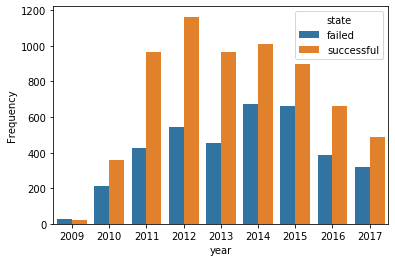

In [21]:
ks_theater = ks_freq[ks_freq['main_category']=='Theater']
sns.barplot(x='year',y='Frequency', hue='state',data=ks_theater)

Generating cases of success and failure overtime by types of projects

<Figure size 1296x720 with 0 Axes>

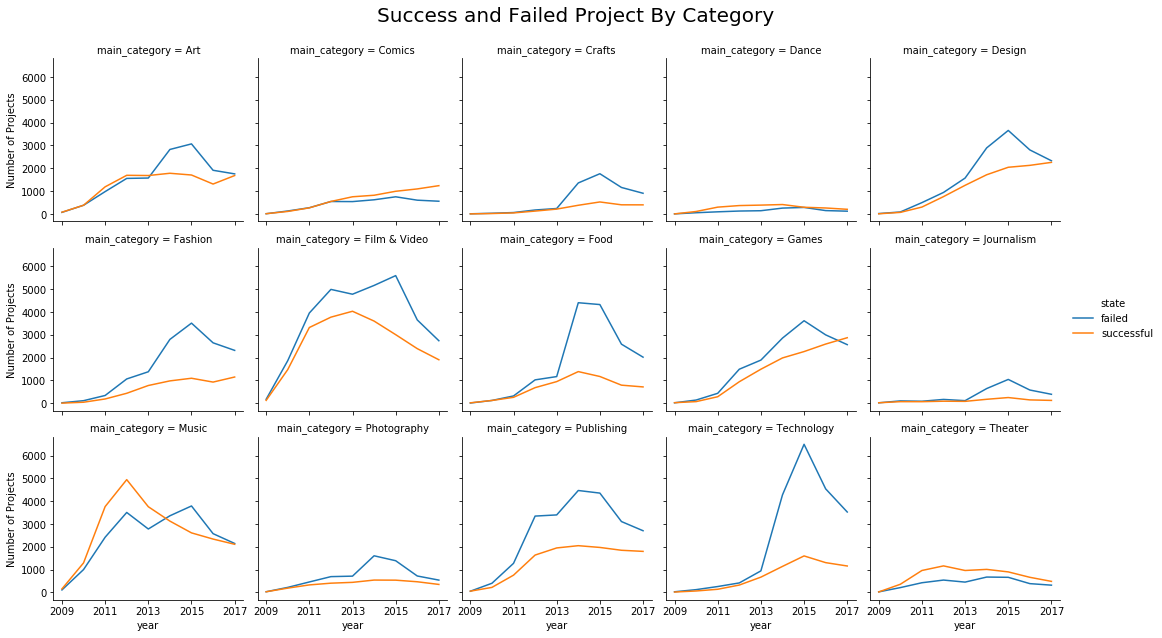

In [22]:
plt.figure(figsize=(18, 10))

g = sns.FacetGrid(ks_freq, col="main_category", hue="state", col_wrap=5)
g.map(sns.lineplot, "year","Frequency").add_legend()
g.despine()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Success and Failed Project By Category", size = 20)
g.set_ylabels('Number of Projects')

plt.xticks(np.arange(2009, 2018, step=2))
g.savefig('Success vs Fail By Cat.png', dpi=400)

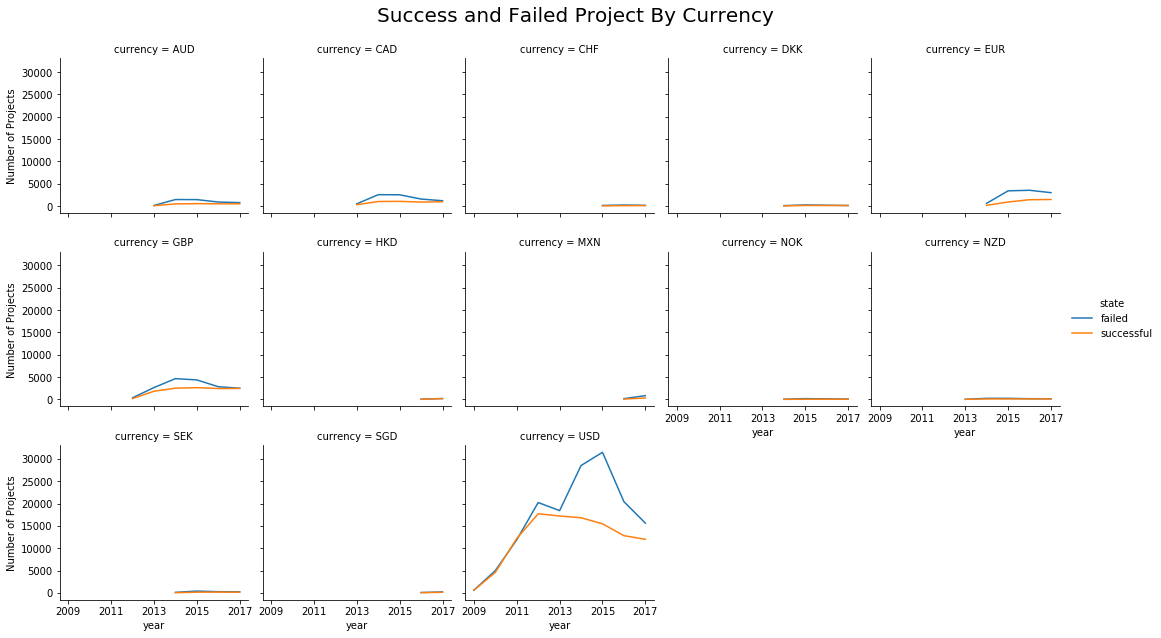

In [24]:
g = sns.FacetGrid(ks_curr, col="currency", hue="state", col_wrap=5)
g.map(sns.lineplot, "year","Frequency").add_legend()
g.despine()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Success and Failed Project By Currency", size = 20)
g.set_ylabels('Number of Projects')

plt.xticks(np.arange(2009, 2018, step=2))
g.savefig('Success vs Fail By Currency.png', dpi=400)

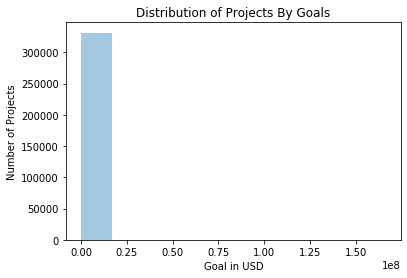

In [25]:
g = sns.distplot(ks['usd_goal_real'], bins=10, kde=False)
plt.title('Distribution of Projects By Goals')
plt.xlabel('Goal in USD')
plt.ylabel('Number of Projects')
plt.savefig('Goal Unscaled.png', dpi=100)

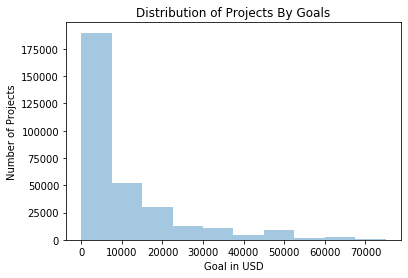

In [26]:
x = ks[ks['usd_goal_real']<ks['usd_goal_real'].quantile(0.95)]
g  = sns.distplot(x['usd_goal_real'], bins=10, kde=False)
plt.title('Distribution of Projects By Goals')
plt.xlabel('Goal in USD')
plt.ylabel('Number of Projects')
plt.savefig('Goal Scaled.png', dpi=100)

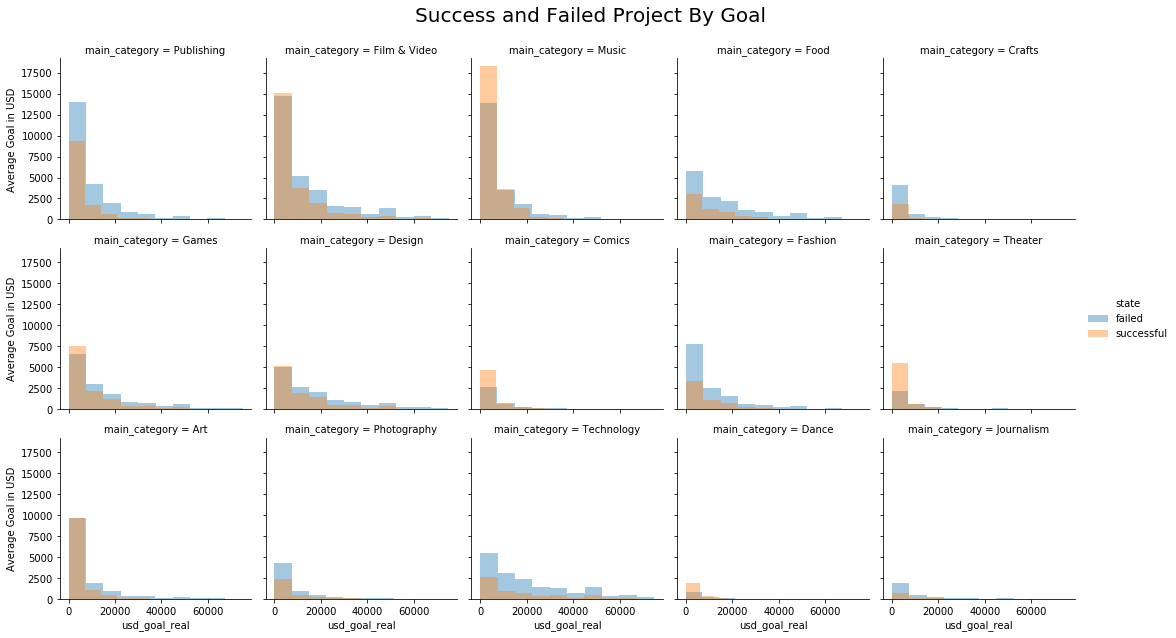

In [28]:
g = sns.FacetGrid(x, col="main_category", hue="state", col_wrap=5)
g.map(sns.distplot, "usd_goal_real", bins=10, kde = False).add_legend()
g.despine()

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Success and Failed Project By Goal", size = 20)
g.set_ylabels('Average Goal in USD')

g.savefig('Success vs Fail By Goal.png', dpi=400)

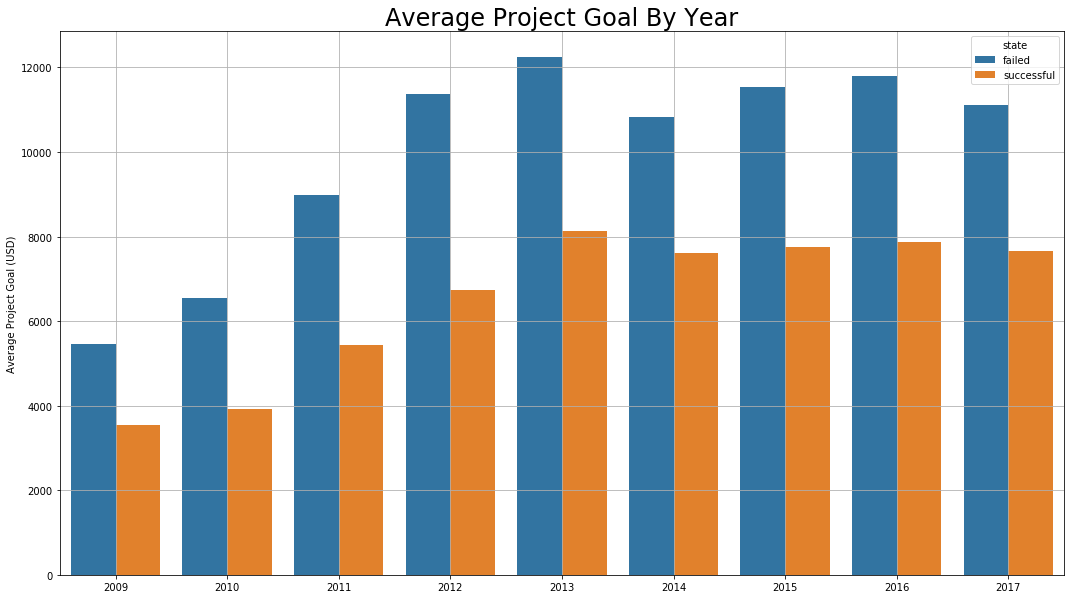

In [31]:
ks_goal = x.groupby(['main_category','state','year']).mean()[['usd_goal_real']]
ks_goal = ks_goal.reset_index()
ks_goalyear = ks_goal.groupby(['state','year']).mean().reset_index()

plt.figure(figsize=(18, 10))
sns.barplot(x="year", y="usd_goal_real", hue = 'state', data=ks_goalyear)

ax = plt.gca()
ax.set(xlabel='', ylabel='Average Project Goal (USD)')
ax.set_title('Average Project Goal By Year', size = 24)
ax.grid(b=True, which='major')
ax.grid(b=True, which='major')

plt.savefig('Average Project Goal By Year.png', dpi=400)

In [31]:
#ks_goal = x.groupby(['main_category','state']).mean()[['usd_goal_real']].reset_index()

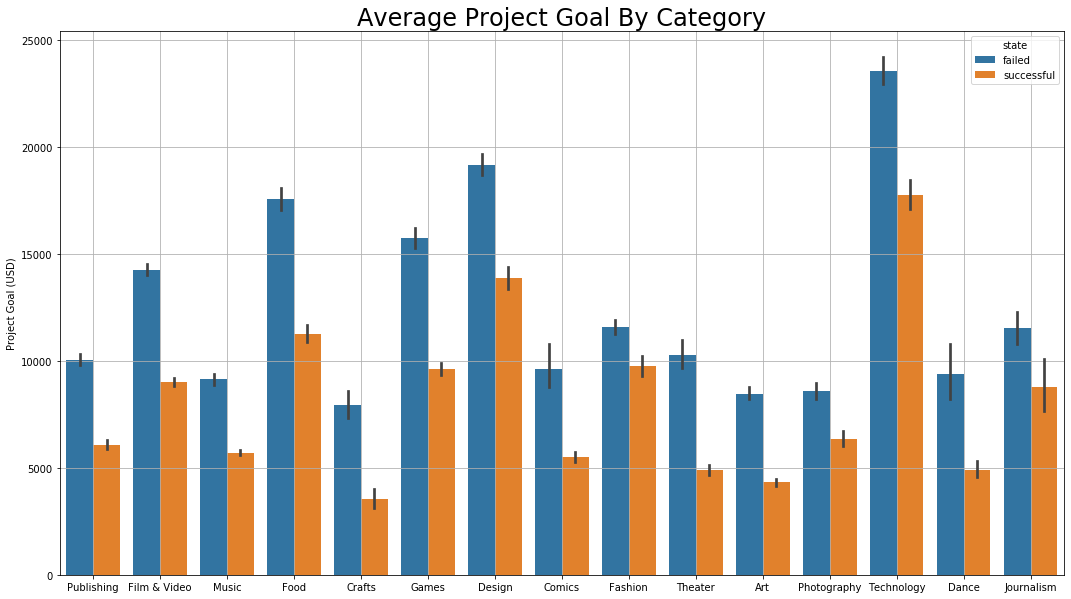

In [32]:
plt.figure(figsize=(18, 10))
sns.barplot(x="main_category", y="goal", hue = 'state', data=x)

ax = plt.gca()
ax.set(xlabel='', ylabel='Project Goal (USD)')
ax.set_title('Average Project Goal By Category', size = 24)
ax.grid(b=True, which='major')
ax.grid(b=True, which='major')

plt.savefig('Average Project Goal By Category.png', dpi=400)

In [33]:
ks_rate = ks_freq.groupby(['main_category','state']).sum()
ks_rate = pd.pivot_table(ks_freq, index='main_category', columns='state', aggfunc=sum)
ks_rate.columns = ['failed','successful']
ks_rate['total'] = ks_rate['failed'] + ks_rate['successful']
ks_rate['failed'] = ks_rate['failed']/ks_rate['total'] 
ks_rate['successful'] = ks_rate['successful']/ks_rate['total'] 
ks_rate = ks_rate.drop(columns='total')
ks_rate = ks_rate.reset_index()
ks_rate = ks_rate.melt('main_category', var_name='state', value_name='rate')

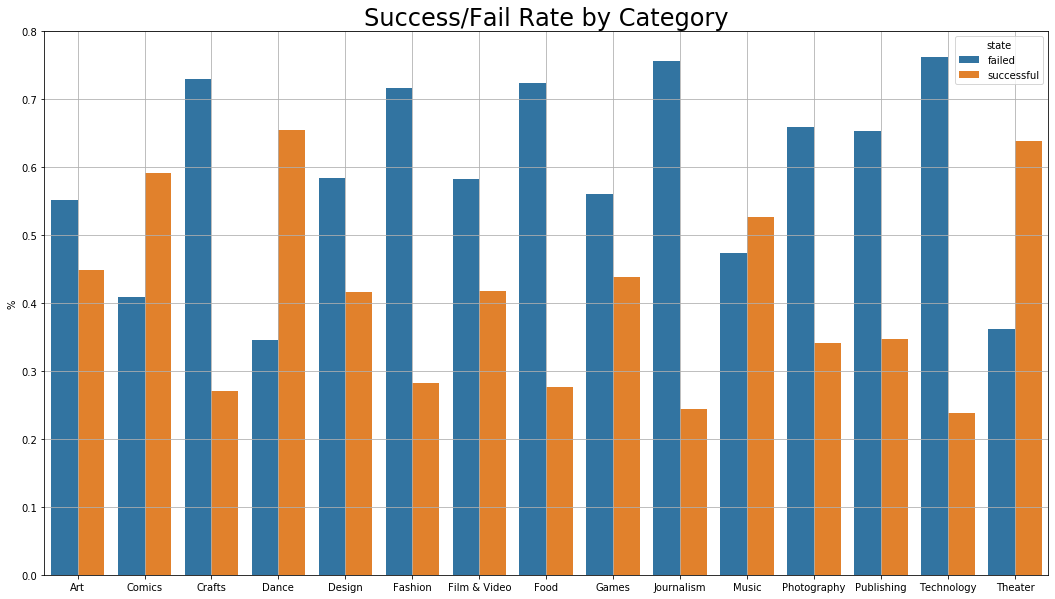

In [34]:
plt.figure(figsize=(18, 10))
sns.barplot(x="main_category", y="rate", hue = "state", data=ks_rate)

ax = plt.gca()
ax.set(xlabel='', ylabel='%')
ax.set_title('Success/Fail Rate by Category', size = 24)
ax.grid(b=True, which='major')
ax.grid(b=True, which='major')

plt.savefig('Success Fail Rate by Category.png', dpi=100)

In [35]:
ks_rate2 = ks_curr.groupby(['currency','state']).sum()
ks_rate2 = pd.pivot_table(ks_rate2, index='currency', columns='state', aggfunc=sum)
ks_rate2.columns = ['failed','successful']
ks_rate2['total'] = ks_rate2['failed'] + ks_rate2['successful']
ks_rate2['failed'] = ks_rate2['failed']/ks_rate2['total'] 
ks_rate2['successful'] = ks_rate2['successful']/ks_rate2['total'] 
ks_rate2 = ks_rate2.drop(columns='total')
ks_rate2 = ks_rate2.reset_index()
ks_rate2 = ks_rate2.melt('currency', var_name='state', value_name='rate')

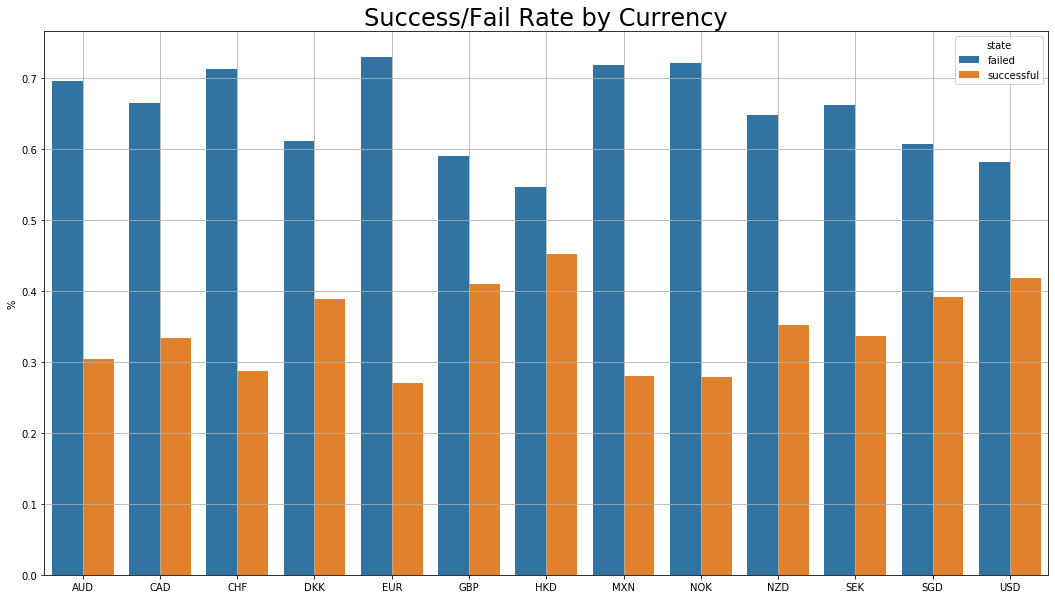

In [36]:
plt.figure(figsize=(18, 10))
sns.barplot(x="currency", y="rate", hue = "state", data=ks_rate2)

ax = plt.gca()
ax.set(xlabel='', ylabel='%')
ax.set_title('Success/Fail Rate by Currency', size = 24)
ax.grid(b=True, which='major')
ax.grid(b=True, which='major')

plt.savefig('Success Fail Rate by Currency.png', dpi=100)

In [37]:
ks_rate3 = ks_curr.groupby(['state','year']).sum()
ks_rate3 = pd.pivot_table(ks_rate3, index='year', columns='state', aggfunc=sum)
ks_rate3.columns = ['failed','successful']
ks_rate3['total'] = ks_rate3['failed'] + ks_rate3['successful']
ks_rate3['failed'] = ks_rate3['failed']/ks_rate3['total'] 
ks_rate3['successful'] = ks_rate3['successful']/ks_rate3['total'] 
ks_rate3 = ks_rate3.drop(columns='total')
ks_rate3 = ks_rate3.reset_index()
ks_rate3 = ks_rate3.melt('year', var_name='state', value_name='rate')
ks_rate3

,year,state,rate
0,2009,failed,0.508906
1,2010,failed,0.520413
2,2011,failed,0.493887
3,2012,failed,0.535007
4,2013,failed,0.527794
5,2014,failed,0.644111
6,2015,failed,0.678714
7,2016,failed,0.619623
8,2017,failed,0.574730
9,2009,successful,0.491094


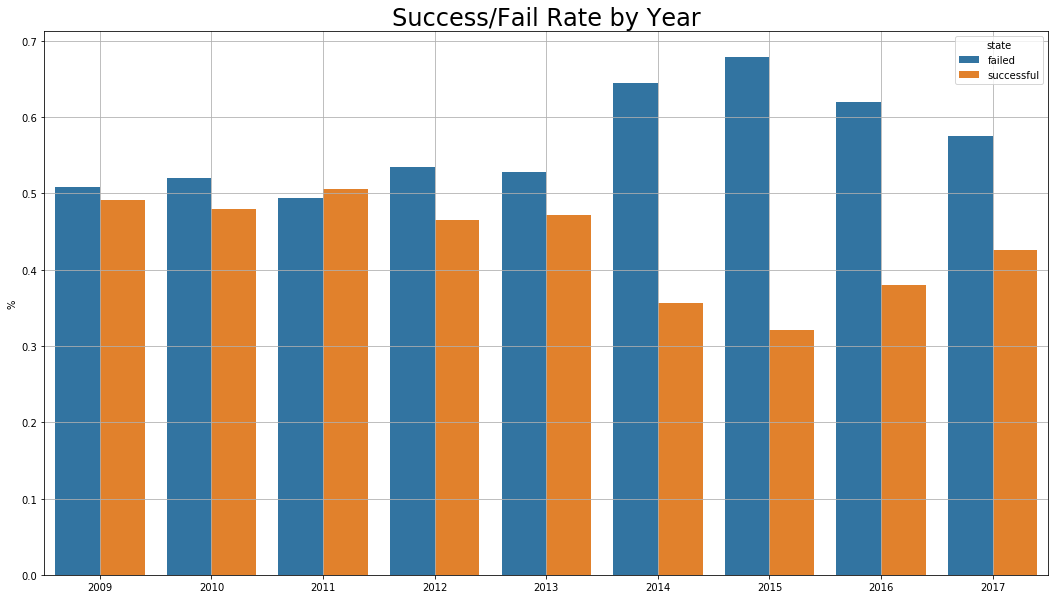

In [38]:
plt.figure(figsize=(18, 10))
sns.barplot(x="year", y="rate", hue = "state", data=ks_rate3)

ax = plt.gca()
ax.set(xlabel='', ylabel='%')
ax.set_title('Success/Fail Rate by Year', size = 24)
ax.grid(b=True, which='major')
ax.grid(b=True, which='major')

plt.savefig('Success Fail Rate by Year.png', dpi=100)

## Feature Processing

In [39]:
numeric = ['usd_goal_real','daysavailable']
cat = ['main_category','currency','year']

numpipe = Pipeline([
        ('nummiss', SimpleImputer(missing_values=np.nan, strategy="mean")),
        ('std_scaler', StandardScaler()
        )])

catpipe = Pipeline([
        ('catmiss', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ('hot', OneHotEncoder(drop="first")
        )])

transform = ColumnTransformer(transformers=[
        ('num', numpipe, numeric),
        ('cat', catpipe, cat)],
        remainder='drop')

In [40]:
finaldata = transform.fit_transform(X)
finaldata = pd.DataFrame(finaldata.toarray(),
                        columns=(numeric +
                                list(transform.named_transformers_['cat']['hot'].get_feature_names(cat))))

finaldata

,usd_goal_real,daysavailable,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,...,currency_SGD,currency_USD,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017
0,-0.467470,1.980583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.519284,2.059457,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.039247,0.876345,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.347322,-0.306768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.212568,0.087603,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328078,-0.295326,-0.306768,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
328079,-0.468647,-0.543390,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
328080,-0.000680,0.955219,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
328081,-0.000680,-0.227894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Model Selection

In [41]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(finaldata,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

In [43]:
#fit the model
pipe = Pipeline([('classifier', LogisticRegression(solver='lbfgs'))])
search_space = [{'classifier': [LogisticRegression(solver='lbfgs')],
                 'classifier__C': [0.01, 0.1, 1.0]},
                {'classifier': [RandomForestClassifier(random_state = 123)],
                 'classifier__n_estimators': [10, 50, 100],
                 'classifier__max_depth': [None, 10, 20]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors':[1,10,20]}]
                
clf = GridSearchCV(pipe, search_space, cv=5, verbose=10, n_jobs=-1)
best_model=clf.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 12.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 18.4min finished


In [44]:
best_model.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [45]:
print('Best Model Training Error: {} '.format(round(1-best_model.score(X_train,y_train),5)))
print('Best Model Cross Validated Error: {} '.format(round(1-best_model.best_score_,5)))
print('Best Model Test Error:{}'.format(round(1-best_model.score(X_test,y_test),5)))

Best Model Training Error: 0.25867 
Best Model Cross Validated Error: 0.33839 
Best Model Test Error:0.33531


In [46]:
best_model.cv_results_['mean_test_score']

array([0.64664376, 0.64655232, 0.64651422, 0.62739936, 0.62830996,
       0.62812327, 0.65001563, 0.65184443, 0.65201969, 0.65653456,
       0.66130089, 0.66161331, 0.5913947 , 0.64316521, 0.65169965])

## Random Forest Select Feature

In [49]:
sig_var = pd.DataFrame({'var':X_train.columns,'importance':best_model.best_estimator_[0].feature_importances_}).sort_values(by='importance', ascending = False)
sig_var.head()

,var,importance
0,usd_goal_real,0.455385
1,daysavailable,0.262943
11,main_category_Music,0.024480
15,main_category_Theater,0.021582
14,main_category_Technology,0.021065


In [50]:
X2 = X.drop(columns=['currency','year'])
X2.head()

,main_category,usd_goal_real,daysavailable
0,Publishing,1533.95,58
1,Film & Video,30000.00,59
2,Film & Video,45000.00,44
3,Music,5000.00,29
5,Food,50000.00,34


In [51]:
numeric = ['usd_goal_real','daysavailable']
cat = ['main_category']

transform2 = ColumnTransformer(transformers=[
        ('num', numpipe, numeric),
        ('cat', catpipe, cat)],
        remainder='drop')


In [52]:
trimmdata = transform2.fit_transform(X2)
trimmdata = pd.DataFrame(trimmdata.toarray(),
                        columns=(numeric +
                                list(transform2.named_transformers_['cat']['hot'].get_feature_names(cat))))

X_train2, X_test2, y_train2, y_test2 = train_test_split(trimmdata,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

In [55]:
best_model2 = best_model.best_estimator_.get_params()['classifier'].fit(X_train2,y_train2)
cv_score = cross_validate(best_model.best_estimator_.get_params()['classifier'],X_train2,y_train2,cv=10,return_train_score=True)

In [56]:
print('Best Model Training Error: {} '.format(round(1-best_model2.score(X_train2,y_train2),5)))
print('Best Model Cross Validated Error: {} '.format(round(1-cv_score['test_score'].mean(),5)))
print('Best Model Test Error:{}'.format(round(1-best_model2.score(X_test2,y_test2),5)))

Best Model Training Error: 0.27565 
Best Model Cross Validated Error: 0.34978 
Best Model Test Error:0.34933


## Model Testing With Backers And Pledged

In [57]:
X3 = ks_dropped.drop(columns = ['ID','name','category','deadline','goal','launched','pledged','state','country','usd pledged'])
X3.head()

,main_category,currency,backers,usd_pledged_real,usd_goal_real,year,daysavailable
0,Publishing,GBP,0,0.0,1533.95,2015,58
1,Film & Video,USD,15,2421.0,30000.00,2017,59
2,Film & Video,USD,3,220.0,45000.00,2013,44
3,Music,USD,1,1.0,5000.00,2012,29
5,Food,USD,224,52375.0,50000.00,2016,34


In [58]:
numeric = ['usd_goal_real','daysavailable','backers','usd_pledged_real']
cat = ['main_category']

transform3 = ColumnTransformer(transformers=[
        ('num', numpipe, numeric),
        ('cat', catpipe, cat)],
        remainder='drop')

finaldf = transform3.fit_transform(X3)
finaldf = pd.DataFrame(finaldf.toarray(),
                        columns=(numeric +
                                list(transform3.named_transformers_['cat']['hot'].get_feature_names(cat))))

In [59]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(finaldf,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

In [60]:
X_train3.head()

,usd_goal_real,daysavailable,backers,usd_pledged_real,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
117137,-0.499845,2.059457,-0.122829,-0.106706,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107494,0.379192,0.481974,-0.047559,0.223373,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36578,-0.413796,-0.149020,-0.032506,-0.080654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
33513,-0.174001,1.349590,-0.135373,-0.120149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1404,-0.347322,-1.095510,-0.035015,-0.053650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [61]:
best_model3 = best_model.best_estimator_.get_params()['classifier'].fit(X_train3,y_train3)
cv_score = cross_validate(best_model.best_estimator_.get_params()['classifier'],X_train3,y_train3,cv=5,return_train_score=True)

In [62]:
print('Best Model Training Error: {} '.format(round(1-best_model3.score(X_train3,y_train3),5)))
print('Best Model Cross Validated Error: {} '.format(round(1-cv_score['test_score'].mean(),5)))
print('Best Model Test Error:{}'.format(round(1-best_model3.score(X_test3,y_test3),5)))

Best Model Training Error: 0.00011 
Best Model Cross Validated Error: 0.00277 
Best Model Test Error:0.0029


In [63]:
pd.DataFrame({'var':X_train3.columns,'importance':best_model.best_estimator_[0].feature_importances_}).sort_values(by='importance', ascending = False)

,var,importance
3,usd_pledged_real,0.389769
2,backers,0.336246
0,usd_goal_real,0.240481
1,daysavailable,0.015460
13,main_category_Music,0.003691
16,main_category_Technology,0.003546
7,main_category_Design,0.002077
11,main_category_Games,0.002024
17,main_category_Theater,0.001926
10,main_category_Food,0.001269


## Random Forest Tuning

In [64]:
max_depth = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
n_estimators = [50]
df = pd.DataFrame([[0 for x in range(len(n_estimators))] for y in range(len(max_depth))])
df.columns= n_estimators
df.index=max_depth

df_validate = df.copy()

In [65]:
for i in max_depth:
    for j in n_estimators:
        if i=='None':
            RF = RandomForestClassifier(n_estimators=j, max_depth=None, random_state=123).fit(X_train, y_train)
        else:
            RF = RandomForestClassifier(n_estimators=j, max_depth=i, random_state=123).fit(X_train, y_train)
            cv_score = cross_validate(RF,X_train,y_train,cv=10,return_train_score=True)

        df.loc[i,j]= 1 - RF.score(X_train, y_train)
        df_validate.loc[i,j]= 1- cv_score['test_score'].mean()

In [66]:
y_test['state'].value_counts()/len(y_test['state'])

failed        0.593307
successful    0.406693
Name: state, dtype: float64

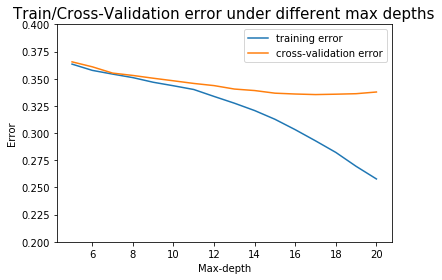

In [67]:
plt.plot(max_depth,df, label = 'training error')
plt.plot(max_depth,df_validate, label = 'cross-validation error')
plt.legend(loc="upper right", markerscale= 0.1)
plt.xlabel("Max-depth", fontsize="10")
plt.ylabel("Error", fontsize="10")
plt.title("Train/Cross-Validation error under different max depths",fontsize="15") 
plt.ylim((0.20,0.40))

plt.savefig('Train vs Cross Validation Error by Max-Depth.png')

## Final Model

In [68]:
X4 = ks_dropped.drop(columns = ['ID','name','backers','category','deadline','goal','launched','pledged','state','country','usd pledged','usd_pledged_real','year','currency'])
numeric = ['usd_goal_real','daysavailable']
cat = ['main_category']

transform4 = ColumnTransformer(transformers=[
        ('num', numpipe, numeric),
        ('cat', catpipe, cat)],
        remainder='drop')

finaldf = transform4.fit_transform(X4)
finaldf = pd.DataFrame(finaldf.toarray(),
                        columns=(numeric +
                                list(transform4.named_transformers_['cat']['hot'].get_feature_names(cat))))

X_train4, X_test4, y_train4, y_test4 = train_test_split(finaldf,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

In [69]:
finalmodel = RandomForestClassifier(n_estimators=50, max_depth=17, random_state=123).fit(X_train4, y_train4)

In [70]:
finalmodel.score(X_test4,y_test4)

0.6562476187573342

In [71]:
finalmodel.predict_proba(X_test4)

array([[0.80051664, 0.19948336],
       [0.37433045, 0.62566955],
       [0.57302313, 0.42697687],
       ...,
       [0.43586429, 0.56413571],
       [0.63736091, 0.36263909],
       [0.76927219, 0.23072781]])